<a href="https://colab.research.google.com/github/rer64064/PORA3/blob/main/%E4%B8%8A%E4%BC%A0goo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/sokrypton/ColabFold/main/.github/ColabFold_Marv_Logo_Small.png" height="200" align="right" style="height:240px">

##ColabFold v1.5.5: AlphaFold2 using MMseqs2

Easy to use protein structure and complex prediction using [AlphaFold2](https://www.nature.com/articles/s41586-021-03819-2) and [Alphafold2-multimer](https://www.biorxiv.org/content/10.1101/2021.10.04.463034v1). Sequence alignments/templates are generated through [MMseqs2](mmseqs.com) and [HHsearch](https://github.com/soedinglab/hh-suite). For more details, see <a href="#Instructions">bottom</a> of the notebook, checkout the [ColabFold GitHub](https://github.com/sokrypton/ColabFold) and [Nature Protocols](https://www.nature.com/articles/s41596-024-01060-5).

Old versions: [v1.4](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.4.0/AlphaFold2.ipynb), [v1.5.1](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.5.1/AlphaFold2.ipynb), [v1.5.2](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.5.2/AlphaFold2.ipynb), [v1.5.3-patch](https://colab.research.google.com/github/sokrypton/ColabFold/blob/56c72044c7d51a311ca99b953a71e552fdc042e1/AlphaFold2.ipynb)

[Mirdita M, Schütze K, Moriwaki Y, Heo L, Ovchinnikov S, Steinegger M. ColabFold: Making protein folding accessible to all.
*Nature Methods*, 2022](https://www.nature.com/articles/s41592-022-01488-1)

In [1]:
#@title Input protein sequence(s), then hit `Runtime` -> `Run all`
from google.colab import files
import os
import re
import hashlib
import random

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

query_sequence = 'TPLEEAIKDIDVSGVLRYRYDTGRFGDRGYGFQDQRSSINDRQNHNYRAQVNLSTAIADNFKAFVQFNYSAKDGGYGADSVSNTSNTFSVRQLYLTYTNEDVATSVILGKQQLNTIWTDNGIDGLVGTGVKVVNNSIDGLTLAAFAVDSFNTDTEGDILASSKLFNSATTNPAGAPQDGTLLNVNPYAGNLYGAAAIGSYEVLGGQLNPQLWLSYLNDTGFFYALDVAYSTTIFDGINWTLKGTYLGNSLDSKMKSKDTIIATEYVGGVGTDVTGEEAMANGNLFALKGAIEVNGWDASLGGIYYGKKDKLTFNTLEDVGNLDLAGAEIFYTDGSNLNGDIGRNIFGYVTAGYTFNETVRVGADLVYGGTKTMDNSGGEKLEAVARVSYKYSPKLNFSAFYSYVNVSNDNQGQEDGRKNTVRLQALYKF:TPLEEAIKDIDVSGVLRYRYDTGRFGDRGYGFQDQRSSINDRQNHNYRAQVNLSTAIADNFKAFVQFNYSAKDGGYGADSVSNTSNTFSVRQLYLTYTNEDVATSVILGKQQLNTIWTDNGIDGLVGTGVKVVNNSIDGLTLAAFAVDSFNTDTEGDILASSKLFNSATTNPAGAPQDGTLLNVNPYAGNLYGAAAIGSYEVLGGQLNPQLWLSYLNDTGFFYALDVAYSTTIFDGINWTLKGTYLGNSLDSKMKSKDTIIATEYVGGVGTDVTGEEAMANGNLFALKGAIEVNGWDASLGGIYYGKKDKLTFNTLEDVGNLDLAGAEIFYTDGSNLNGDIGRNIFGYVTAGYTFNETVRVGADLVYGGTKTMDNSGGEKLEAVARVSYKYSPKLNFSAFYSYVNVSNDNQGQEDGRKNTVRLQALYKF:TPLEEAIKDIDVSGVLRYRYDTGRFGDRGYGFQDQRSSINDRQNHNYRAQVNLSTAIADNFKAFVQFNYSAKDGGYGADSVSNTSNTFSVRQLYLTYTNEDVATSVILGKQQLNTIWTDNGIDGLVGTGVKVVNNSIDGLTLAAFAVDSFNTDTEGDILASSKLFNSATTNPAGAPQDGTLLNVNPYAGNLYGAAAIGSYEVLGGQLNPQLWLSYLNDTGFFYALDVAYSTTIFDGINWTLKGTYLGNSLDSKMKSKDTIIATEYVGGVGTDVTGEEAMANGNLFALKGAIEVNGWDASLGGIYYGKKDKLTFNTLEDVGNLDLAGAEIFYTDGSNLNGDIGRNIFGYVTAGYTFNETVRVGADLVYGGTKTMDNSGGEKLEAVARVSYKYSPKLNFSAFYSYVNVSNDNQGQEDGRKNTVRLQALYKF' #@param {type:"string"}
#@markdown  - Use `:` to specify inter-protein chainbreaks for **modeling complexes** (supports homo- and hetro-oligomers). For example **PI...SK:PI...SK** for a homodimer
jobname = '33559PORA' #@param {type:"string"}
# number of models to use
num_relax = 10 #@param [0, 1, 5] {type:"raw"}
#@markdown - specify how many of the top ranked structures to relax using amber
template_mode = "pdb100" #@param ["none", "pdb100","custom"]
#@markdown - `none` = no template information is used. `pdb100` = detect templates in pdb100 (see [notes](#pdb100)). `custom` - upload and search own templates (PDB or mmCIF format, see [notes](#custom_templates))

use_amber = num_relax > 0

# remove whitespaces
query_sequence = "".join(query_sequence.split())

basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)

# check if directory with jobname exists
def check(folder):
  if os.path.exists(folder):
    return False
  else:
    return True
if not check(jobname):
  n = 0
  while not check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

# make directory to save results
os.makedirs(jobname, exist_ok=True)

# save queries
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
  text_file.write(f"id,sequence\n{jobname},{query_sequence}")

if template_mode == "pdb100":
  use_templates = True
  custom_template_path = None
elif template_mode == "custom":
  custom_template_path = os.path.join(jobname,f"template")
  os.makedirs(custom_template_path, exist_ok=True)
  uploaded = files.upload()
  use_templates = True
  for fn in uploaded.keys():
    os.rename(fn,os.path.join(custom_template_path,fn))
else:
  custom_template_path = None
  use_templates = False

print("jobname",jobname)
print("sequence",query_sequence)
print("length",len(query_sequence.replace(":","")))

jobname 33559PORA_8188f
sequence TPLEEAIKDIDVSGVLRYRYDTGRFGDRGYGFQDQRSSINDRQNHNYRAQVNLSTAIADNFKAFVQFNYSAKDGGYGADSVSNTSNTFSVRQLYLTYTNEDVATSVILGKQQLNTIWTDNGIDGLVGTGVKVVNNSIDGLTLAAFAVDSFNTDTEGDILASSKLFNSATTNPAGAPQDGTLLNVNPYAGNLYGAAAIGSYEVLGGQLNPQLWLSYLNDTGFFYALDVAYSTTIFDGINWTLKGTYLGNSLDSKMKSKDTIIATEYVGGVGTDVTGEEAMANGNLFALKGAIEVNGWDASLGGIYYGKKDKLTFNTLEDVGNLDLAGAEIFYTDGSNLNGDIGRNIFGYVTAGYTFNETVRVGADLVYGGTKTMDNSGGEKLEAVARVSYKYSPKLNFSAFYSYVNVSNDNQGQEDGRKNTVRLQALYKF:TPLEEAIKDIDVSGVLRYRYDTGRFGDRGYGFQDQRSSINDRQNHNYRAQVNLSTAIADNFKAFVQFNYSAKDGGYGADSVSNTSNTFSVRQLYLTYTNEDVATSVILGKQQLNTIWTDNGIDGLVGTGVKVVNNSIDGLTLAAFAVDSFNTDTEGDILASSKLFNSATTNPAGAPQDGTLLNVNPYAGNLYGAAAIGSYEVLGGQLNPQLWLSYLNDTGFFYALDVAYSTTIFDGINWTLKGTYLGNSLDSKMKSKDTIIATEYVGGVGTDVTGEEAMANGNLFALKGAIEVNGWDASLGGIYYGKKDKLTFNTLEDVGNLDLAGAEIFYTDGSNLNGDIGRNIFGYVTAGYTFNETVRVGADLVYGGTKTMDNSGGEKLEAVARVSYKYSPKLNFSAFYSYVNVSNDNQGQEDGRKNTVRLQALYKF:TPLEEAIKDIDVSGVLRYRYDTGRFGDRGYGFQDQRSSINDRQNHNYRAQVNLSTAIADNFKAFVQFNYSAKDGGYGADSVSNTSNTFSVRQLYLTYTNEDVATSVI

In [2]:
#@title Install dependencies
%%time
import os
USE_AMBER = use_amber
USE_TEMPLATES = use_templates
PYTHON_VERSION = python_version

if not os.path.isfile("COLABFOLD_READY"):
  print("installing colabfold...")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
  if os.environ.get('TPU_NAME', False) != False:
    os.system("pip uninstall -y jax jaxlib")
    os.system("pip install --no-warn-conflicts --upgrade dm-haiku==0.0.10 'jax[cuda12_pip]'==0.3.25 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  os.system("touch COLABFOLD_READY")

if USE_AMBER or USE_TEMPLATES:
  if not os.path.isfile("CONDA_READY"):
    print("installing conda...")
    os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Miniforge3-Linux-x86_64.sh")
    os.system("bash Miniforge3-Linux-x86_64.sh -bfp /usr/local")
    os.system("mamba config --set auto_update_conda false")
    os.system("touch CONDA_READY")

if USE_TEMPLATES and not os.path.isfile("HH_READY") and USE_AMBER and not os.path.isfile("AMBER_READY"):
  print("installing hhsuite and amber...")
  os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=8.2.0 python='{PYTHON_VERSION}' pdbfixer")
  os.system("touch HH_READY")
  os.system("touch AMBER_READY")
else:
  if USE_TEMPLATES and not os.path.isfile("HH_READY"):
    print("installing hhsuite...")
    os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}'")
    os.system("touch HH_READY")
  if USE_AMBER and not os.path.isfile("AMBER_READY"):
    print("installing amber...")
    os.system(f"mamba install -y -c conda-forge openmm=8.2.0 python='{PYTHON_VERSION}' pdbfixer")
    os.system("touch AMBER_READY")

installing colabfold...
installing conda...
installing hhsuite and amber...
CPU times: user 188 ms, sys: 19.2 ms, total: 207 ms
Wall time: 1min 3s


In [3]:
#@markdown ### MSA options (custom MSA upload, single sequence, pairing mode)
msa_mode = "mmseqs2_uniref_env" #@param ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence","custom"]
pair_mode = "unpaired_paired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}
#@markdown - "unpaired_paired" = pair sequences from same species + unpaired MSA, "unpaired" = seperate MSA for each chain, "paired" - only use paired sequences.

# decide which a3m to use
if "mmseqs2" in msa_mode:
  a3m_file = os.path.join(jobname,f"{jobname}.a3m")

elif msa_mode == "custom":
  a3m_file = os.path.join(jobname,f"{jobname}.custom.a3m")
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")

else:
  a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

In [4]:
#@markdown ### Advanced settings
model_type = "alphafold2_multimer_v3" #@param ["auto", "alphafold2_ptm", "alphafold2_multimer_v1", "alphafold2_multimer_v2", "alphafold2_multimer_v3", "deepfold_v1", "alphafold2"]
#@markdown - if `auto` selected, will use `alphafold2_ptm` for monomer prediction and `alphafold2_multimer_v3` for complex prediction.
#@markdown Any of the mode_types can be used (regardless if input is monomer or complex).
num_recycles = "auto" #@param ["auto", "0", "1", "3", "6", "12", "24", "48"]
#@markdown - if `auto` selected, will use `num_recycles=20` if `model_type=alphafold2_multimer_v3`, else `num_recycles=3` .
recycle_early_stop_tolerance = "auto" #@param ["auto", "0.0", "0.5", "1.0"]
#@markdown - if `auto` selected, will use `tol=0.5` if `model_type=alphafold2_multimer_v3` else `tol=0.0`.
relax_max_iterations = 200 #@param [0, 200, 2000] {type:"raw"}
#@markdown - max amber relax iterations, `0` = unlimited (AlphaFold2 default, can take very long)
pairing_strategy = "greedy" #@param ["greedy", "complete"] {type:"string"}
#@markdown - `greedy` = pair any taxonomically matching subsets, `complete` = all sequences have to match in one line.
calc_extra_ptm = True #@param {type:"boolean"}
#@markdown - return pairwise chain iptm/actifptm

#@markdown #### Sample settings
#@markdown -  enable dropouts and increase number of seeds to sample predictions from uncertainty of the model.
#@markdown -  decrease `max_msa` to increase uncertainity
max_msa = "512:1024" #@param ["auto", "512:1024", "256:512", "64:128", "32:64", "16:32"]
num_seeds = 2 #@param [1,2,4,8,16] {type:"raw"}
use_dropout = True #@param {type:"boolean"}

num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
if max_msa == "auto": max_msa = None

#@markdown #### Save settings
save_all = True #@param {type:"boolean"}
save_recycles = False #@param {type:"boolean"}
save_to_google_drive = False #@param {type:"boolean"}
#@markdown -  if the save_to_google_drive option was selected, the result zip will be uploaded to your Google Drive
dpi = 300 #@param {type:"integer"}
#@markdown - set dpi for image resolution

if save_to_google_drive:
  from pydrive2.drive import GoogleDrive
  from pydrive2.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("You are logged into Google Drive and are good to go!")

#@markdown Don't forget to hit `Runtime` -> `Run all` after updating the form.

2025-06-19 09:15:20,210 Running on GPU
2025-06-19 09:15:20,484 Found 9 citations for tools or databases
2025-06-19 09:15:20,484 Query 1/1: 33559PORA_8188f (length 1287)


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:02 remaining: 00:00]


2025-06-19 09:15:27,393 Sequence 0 found templates: ['5ldt_A', '5ldv_A', '5ldv_A']


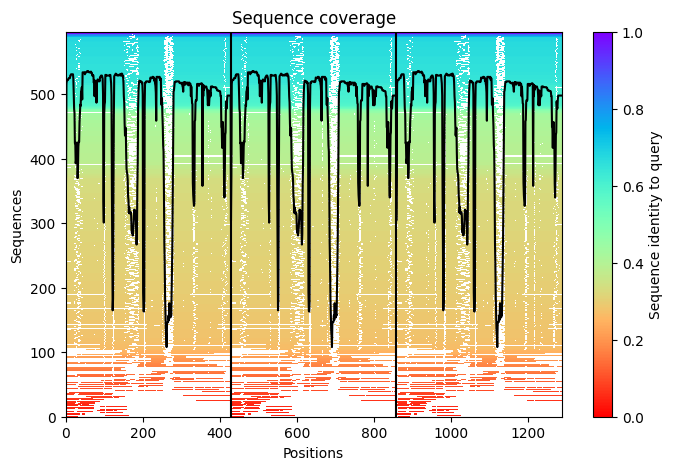

2025-06-19 09:15:28,710 Setting max_seq=512, max_extra_seq=89
2025-06-19 09:18:20,156 alphafold2_multimer_v3_model_1_seed_000 recycle=0 pLDDT=88.1 pTM=0.915 ipTM=0.906
2025-06-19 09:18:58,787 alphafold2_multimer_v3_model_1_seed_000 recycle=1 pLDDT=89.3 pTM=0.924 ipTM=0.917 tol=1.01
2025-06-19 09:19:37,364 alphafold2_multimer_v3_model_1_seed_000 recycle=2 pLDDT=89.2 pTM=0.925 ipTM=0.917 tol=0.447
2025-06-19 09:19:41,264 alphafold2_multimer_v3_model_1_seed_000 took 243.9s (2 recycles)


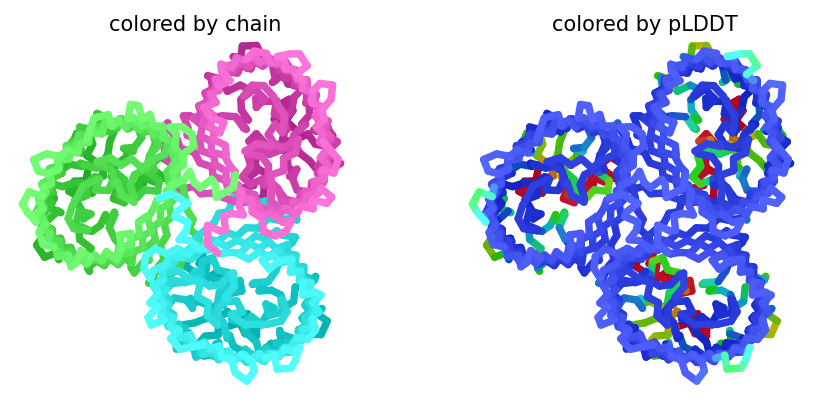

2025-06-19 09:20:22,837 alphafold2_multimer_v3_model_2_seed_000 recycle=0 pLDDT=88.6 pTM=0.912 ipTM=0.9
2025-06-19 09:21:01,396 alphafold2_multimer_v3_model_2_seed_000 recycle=1 pLDDT=89.8 pTM=0.921 ipTM=0.913 tol=1.58
2025-06-19 09:21:39,922 alphafold2_multimer_v3_model_2_seed_000 recycle=2 pLDDT=90.1 pTM=0.921 ipTM=0.912 tol=0.894
2025-06-19 09:22:18,425 alphafold2_multimer_v3_model_2_seed_000 recycle=3 pLDDT=90.7 pTM=0.925 ipTM=0.916 tol=0.709
2025-06-19 09:22:57,044 alphafold2_multimer_v3_model_2_seed_000 recycle=4 pLDDT=95.4 pTM=0.941 ipTM=0.933 tol=0.979
2025-06-19 09:23:35,682 alphafold2_multimer_v3_model_2_seed_000 recycle=5 pLDDT=95.4 pTM=0.942 ipTM=0.934 tol=0.161
2025-06-19 09:23:37,408 alphafold2_multimer_v3_model_2_seed_000 took 233.2s (5 recycles)


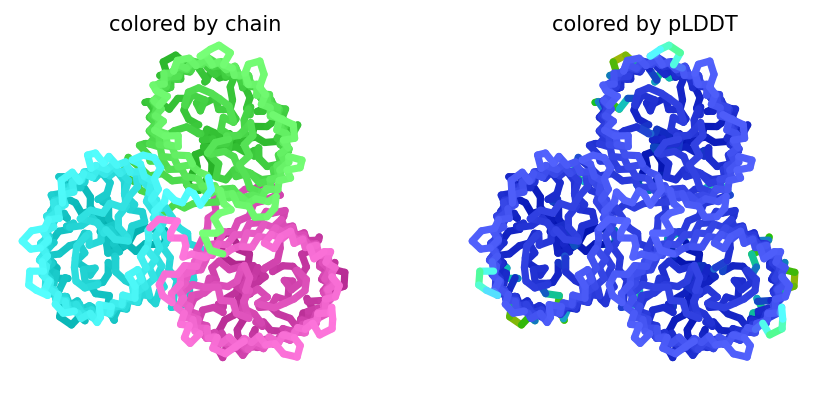

2025-06-19 09:24:19,846 alphafold2_multimer_v3_model_3_seed_000 recycle=0 pLDDT=89.6 pTM=0.924 ipTM=0.915
2025-06-19 09:24:58,956 alphafold2_multimer_v3_model_3_seed_000 recycle=1 pLDDT=92.3 pTM=0.937 ipTM=0.929 tol=1.64
2025-06-19 09:25:37,961 alphafold2_multimer_v3_model_3_seed_000 recycle=2 pLDDT=92.8 pTM=0.936 ipTM=0.929 tol=0.799
2025-06-19 09:26:16,993 alphafold2_multimer_v3_model_3_seed_000 recycle=3 pLDDT=93.2 pTM=0.94 ipTM=0.934 tol=0.811
2025-06-19 09:26:56,083 alphafold2_multimer_v3_model_3_seed_000 recycle=4 pLDDT=93 pTM=0.937 ipTM=0.931 tol=0.402
2025-06-19 09:26:57,800 alphafold2_multimer_v3_model_3_seed_000 took 197.1s (4 recycles)


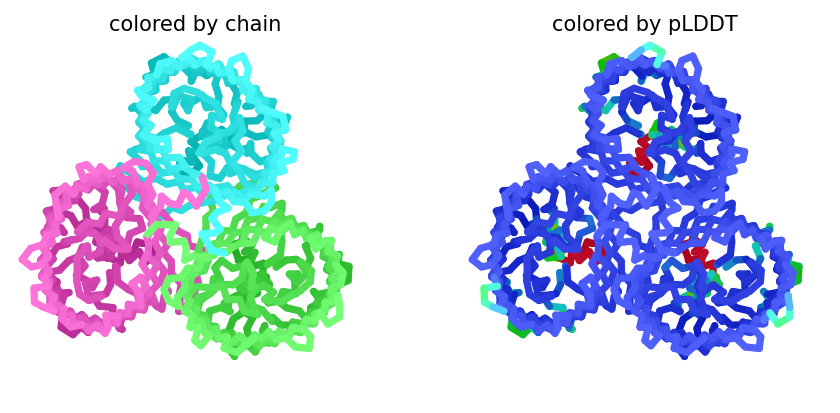

2025-06-19 09:27:39,759 alphafold2_multimer_v3_model_4_seed_000 recycle=0 pLDDT=89.6 pTM=0.924 ipTM=0.915
2025-06-19 09:28:18,602 alphafold2_multimer_v3_model_4_seed_000 recycle=1 pLDDT=90.4 pTM=0.927 ipTM=0.919 tol=1.49
2025-06-19 09:28:57,426 alphafold2_multimer_v3_model_4_seed_000 recycle=2 pLDDT=91.1 pTM=0.934 ipTM=0.926 tol=0.735
2025-06-19 09:29:36,260 alphafold2_multimer_v3_model_4_seed_000 recycle=3 pLDDT=90.9 pTM=0.933 ipTM=0.925 tol=0.391
2025-06-19 09:29:37,992 alphafold2_multimer_v3_model_4_seed_000 took 157.2s (3 recycles)


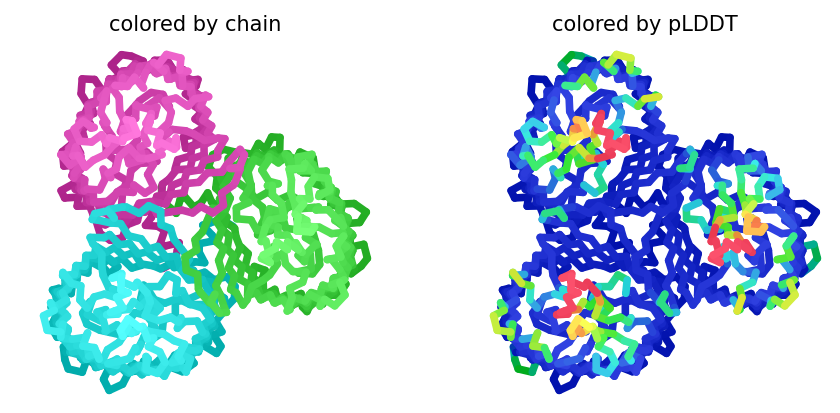

2025-06-19 09:30:19,718 alphafold2_multimer_v3_model_5_seed_000 recycle=0 pLDDT=88.2 pTM=0.915 ipTM=0.904
2025-06-19 09:30:58,488 alphafold2_multimer_v3_model_5_seed_000 recycle=1 pLDDT=90.1 pTM=0.928 ipTM=0.92 tol=1.18
2025-06-19 09:31:37,141 alphafold2_multimer_v3_model_5_seed_000 recycle=2 pLDDT=90 pTM=0.927 ipTM=0.919 tol=0.825
2025-06-19 09:32:15,873 alphafold2_multimer_v3_model_5_seed_000 recycle=3 pLDDT=90.4 pTM=0.928 ipTM=0.921 tol=0.694
2025-06-19 09:32:54,585 alphafold2_multimer_v3_model_5_seed_000 recycle=4 pLDDT=90.9 pTM=0.928 ipTM=0.919 tol=0.611
2025-06-19 09:33:33,293 alphafold2_multimer_v3_model_5_seed_000 recycle=5 pLDDT=91.7 pTM=0.931 ipTM=0.923 tol=0.976
2025-06-19 09:34:12,032 alphafold2_multimer_v3_model_5_seed_000 recycle=6 pLDDT=93.8 pTM=0.938 ipTM=0.93 tol=0.707
2025-06-19 09:34:50,745 alphafold2_multimer_v3_model_5_seed_000 recycle=7 pLDDT=94.4 pTM=0.942 ipTM=0.934 tol=0.262
2025-06-19 09:34:52,472 alphafold2_multimer_v3_model_5_seed_000 took 311.5s (7 recycles

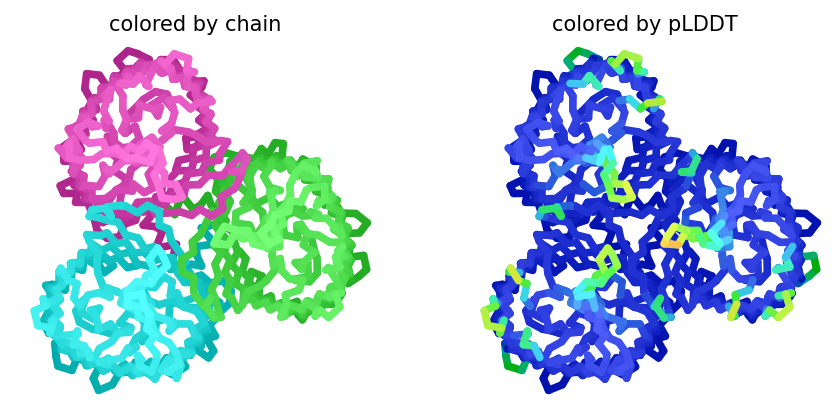

2025-06-19 09:35:34,156 alphafold2_multimer_v3_model_1_seed_001 recycle=0 pLDDT=89.3 pTM=0.918 ipTM=0.909
2025-06-19 09:36:12,810 alphafold2_multimer_v3_model_1_seed_001 recycle=1 pLDDT=91.2 pTM=0.93 ipTM=0.922 tol=1.26
2025-06-19 09:36:51,418 alphafold2_multimer_v3_model_1_seed_001 recycle=2 pLDDT=91.9 pTM=0.933 ipTM=0.925 tol=0.606
2025-06-19 09:37:29,951 alphafold2_multimer_v3_model_1_seed_001 recycle=3 pLDDT=91.7 pTM=0.931 ipTM=0.922 tol=0.875
2025-06-19 09:38:08,538 alphafold2_multimer_v3_model_1_seed_001 recycle=4 pLDDT=92 pTM=0.933 ipTM=0.925 tol=0.409
2025-06-19 09:38:10,261 alphafold2_multimer_v3_model_1_seed_001 took 194.9s (4 recycles)


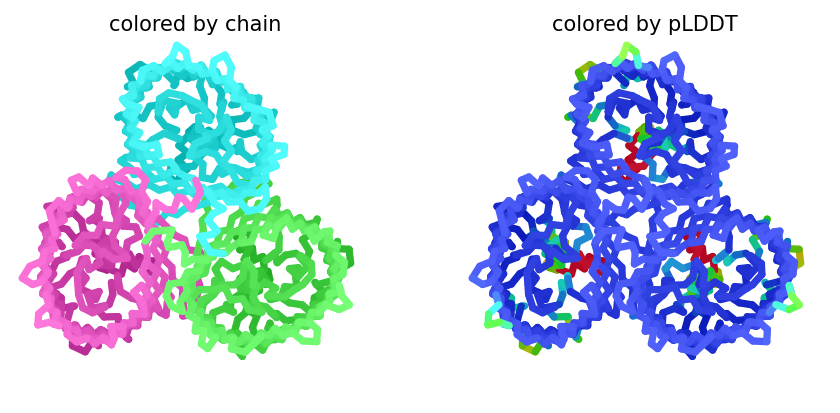

2025-06-19 09:38:51,813 alphafold2_multimer_v3_model_2_seed_001 recycle=0 pLDDT=89.2 pTM=0.912 ipTM=0.901
2025-06-19 09:39:30,368 alphafold2_multimer_v3_model_2_seed_001 recycle=1 pLDDT=89.9 pTM=0.923 ipTM=0.915 tol=1.08
2025-06-19 09:40:08,892 alphafold2_multimer_v3_model_2_seed_001 recycle=2 pLDDT=89.2 pTM=0.918 ipTM=0.909 tol=1.13
2025-06-19 09:40:47,332 alphafold2_multimer_v3_model_2_seed_001 recycle=3 pLDDT=89.2 pTM=0.917 ipTM=0.908 tol=1.69
2025-06-19 09:41:25,848 alphafold2_multimer_v3_model_2_seed_001 recycle=4 pLDDT=90.2 pTM=0.923 ipTM=0.915 tol=1.16
2025-06-19 09:42:04,381 alphafold2_multimer_v3_model_2_seed_001 recycle=5 pLDDT=91 pTM=0.928 ipTM=0.92 tol=1.17
2025-06-19 09:42:42,898 alphafold2_multimer_v3_model_2_seed_001 recycle=6 pLDDT=91.9 pTM=0.931 ipTM=0.923 tol=0.497
2025-06-19 09:42:44,618 alphafold2_multimer_v3_model_2_seed_001 took 271.5s (6 recycles)


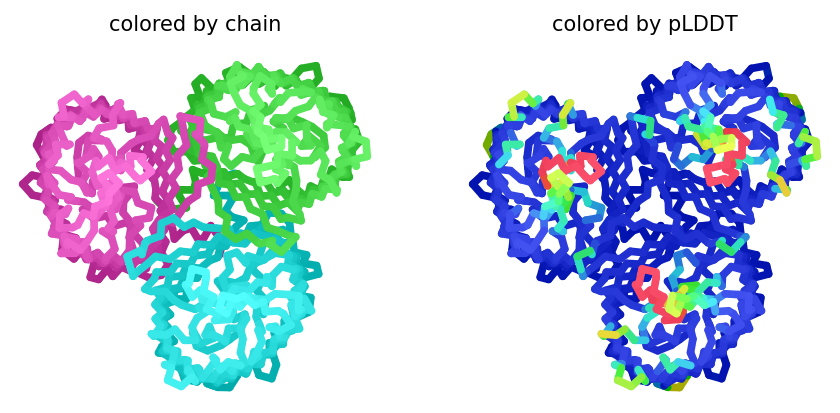

2025-06-19 09:43:26,712 alphafold2_multimer_v3_model_3_seed_001 recycle=0 pLDDT=89.6 pTM=0.924 ipTM=0.916
2025-06-19 09:44:05,734 alphafold2_multimer_v3_model_3_seed_001 recycle=1 pLDDT=90.4 pTM=0.929 ipTM=0.923 tol=1.25
2025-06-19 09:44:44,694 alphafold2_multimer_v3_model_3_seed_001 recycle=2 pLDDT=90.8 pTM=0.93 ipTM=0.923 tol=0.773
2025-06-19 09:45:23,801 alphafold2_multimer_v3_model_3_seed_001 recycle=3 pLDDT=92.6 pTM=0.938 ipTM=0.93 tol=1.02
2025-06-19 09:46:02,859 alphafold2_multimer_v3_model_3_seed_001 recycle=4 pLDDT=92.8 pTM=0.937 ipTM=0.929 tol=0.415
2025-06-19 09:46:04,581 alphafold2_multimer_v3_model_3_seed_001 took 197.0s (4 recycles)


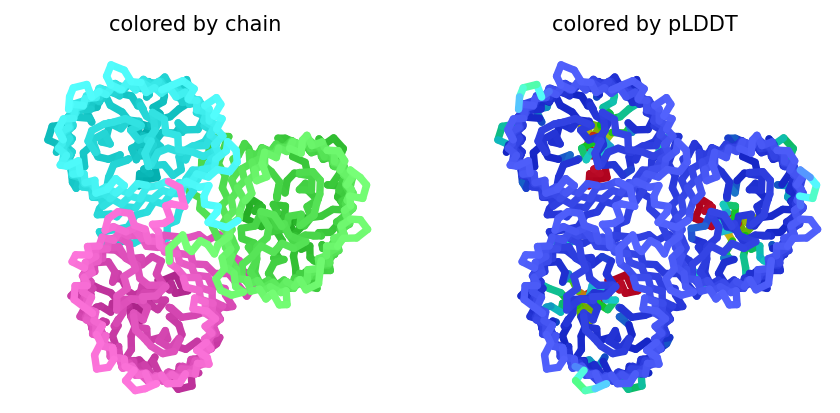

2025-06-19 09:46:46,481 alphafold2_multimer_v3_model_4_seed_001 recycle=0 pLDDT=89.8 pTM=0.924 ipTM=0.915
2025-06-19 09:47:25,403 alphafold2_multimer_v3_model_4_seed_001 recycle=1 pLDDT=91.5 pTM=0.934 ipTM=0.926 tol=1.75
2025-06-19 09:48:04,314 alphafold2_multimer_v3_model_4_seed_001 recycle=2 pLDDT=92.1 pTM=0.936 ipTM=0.928 tol=0.632
2025-06-19 09:48:43,153 alphafold2_multimer_v3_model_4_seed_001 recycle=3 pLDDT=91.9 pTM=0.934 ipTM=0.926 tol=1.13
2025-06-19 09:49:21,997 alphafold2_multimer_v3_model_4_seed_001 recycle=4 pLDDT=92.1 pTM=0.936 ipTM=0.928 tol=0.493
2025-06-19 09:49:23,717 alphafold2_multimer_v3_model_4_seed_001 took 196.2s (4 recycles)


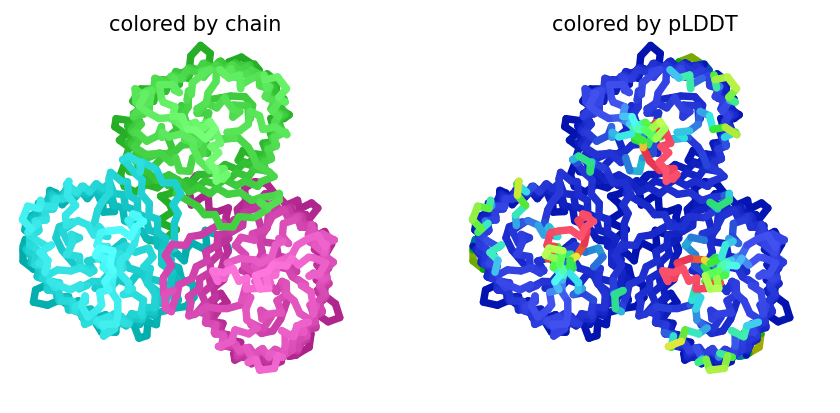

2025-06-19 09:50:05,442 alphafold2_multimer_v3_model_5_seed_001 recycle=0 pLDDT=88.3 pTM=0.913 ipTM=0.903
2025-06-19 09:50:44,126 alphafold2_multimer_v3_model_5_seed_001 recycle=1 pLDDT=89.9 pTM=0.928 ipTM=0.92 tol=1.36
2025-06-19 09:51:22,737 alphafold2_multimer_v3_model_5_seed_001 recycle=2 pLDDT=89.1 pTM=0.922 ipTM=0.915 tol=0.727
2025-06-19 09:52:01,330 alphafold2_multimer_v3_model_5_seed_001 recycle=3 pLDDT=88.4 pTM=0.916 ipTM=0.909 tol=1.42
2025-06-19 09:52:39,906 alphafold2_multimer_v3_model_5_seed_001 recycle=4 pLDDT=88.5 pTM=0.915 ipTM=0.907 tol=0.885
2025-06-19 09:53:18,535 alphafold2_multimer_v3_model_5_seed_001 recycle=5 pLDDT=90.6 pTM=0.926 ipTM=0.918 tol=1.38
2025-06-19 09:53:57,232 alphafold2_multimer_v3_model_5_seed_001 recycle=6 pLDDT=93.1 pTM=0.937 ipTM=0.928 tol=1.82
2025-06-19 09:54:35,970 alphafold2_multimer_v3_model_5_seed_001 recycle=7 pLDDT=93.7 pTM=0.941 ipTM=0.934 tol=0.524
2025-06-19 09:55:14,683 alphafold2_multimer_v3_model_5_seed_001 recycle=8 pLDDT=95 pTM=

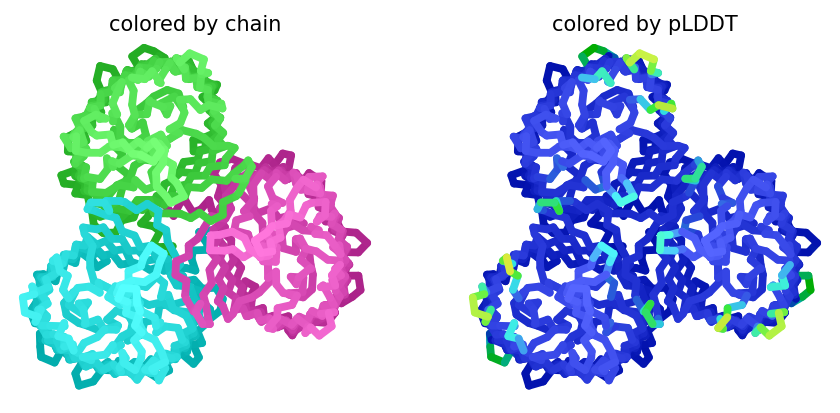

2025-06-19 09:55:58,094 reranking models by 'multimer' metric
2025-06-19 09:57:04,404 Relaxation took 66.3s
2025-06-19 09:57:04,404 rank_001_alphafold2_multimer_v3_model_5_seed_001 pLDDT=95.4 pTM=0.944 ipTM=0.936 actifpTM=0.992
2025-06-19 09:58:02,573 Relaxation took 58.2s
2025-06-19 09:58:02,573 rank_002_alphafold2_multimer_v3_model_5_seed_000 pLDDT=94.4 pTM=0.942 ipTM=0.934 actifpTM=0.992
2025-06-19 09:58:59,957 Relaxation took 57.4s
2025-06-19 09:58:59,958 rank_003_alphafold2_multimer_v3_model_2_seed_000 pLDDT=95.4 pTM=0.942 ipTM=0.934 actifpTM=0.992
2025-06-19 09:59:58,175 Relaxation took 58.2s
2025-06-19 09:59:58,176 rank_004_alphafold2_multimer_v3_model_3_seed_000 pLDDT=93 pTM=0.937 ipTM=0.931 actifpTM=0.993
2025-06-19 10:01:54,618 Relaxation took 116.4s
2025-06-19 10:01:54,618 rank_005_alphafold2_multimer_v3_model_3_seed_001 pLDDT=92.8 pTM=0.937 ipTM=0.929 actifpTM=0.993
2025-06-19 10:02:52,526 Relaxation took 57.9s
2025-06-19 10:02:52,526 rank_006_alphafold2_multimer_v3_model_4

0

In [5]:
#@title Run Prediction
display_images = True #@param {type:"boolean"}

import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2

import os
import numpy as np
try:
  K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
  K80_chk = "0"
  pass
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt

# For some reason we need that to get pdbfixer to import
if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
    sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

def input_features_callback(input_features):
  if display_images:
    plot_msa_v2(input_features)
    plt.show()
    plt.close()

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
  model_name, relaxed = mode
  if not relaxed:
    if display_images:
      fig = plot_protein(protein_obj, Ls=length, dpi=150)
      plt.show()
      plt.close()

result_dir = jobname
log_filename = os.path.join(jobname,"log.txt")
setup_logging(Path(log_filename))

queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

if "multimer" in model_type and max_msa is not None:
  use_cluster_profile = False
else:
  use_cluster_profile = True

download_alphafold_params(model_type, Path("."))
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    num_relax=num_relax,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=5,
    num_recycles=num_recycles,
    relax_max_iterations=relax_max_iterations,
    recycle_early_stop_tolerance=recycle_early_stop_tolerance,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1,2,3,4,5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    pairing_strategy=pairing_strategy,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi,
    zip_results=False,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    input_features_callback=input_features_callback,
    save_recycles=save_recycles,
    user_agent="colabfold/google-colab-main",
    calc_extra_ptm=calc_extra_ptm,
)
results_zip = f"{jobname}.result.zip"
os.system(f"zip -r {results_zip} {jobname}")

In [6]:
#@title Package and download results
#@markdown If you are having issues downloading the result archive, try disabling your adblocker and run this cell again. If that fails click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

if msa_mode == "custom":
  print("Don't forget to cite your custom MSA generation method.")

files.download(f"{jobname}.result.zip")

if save_to_google_drive == True and drive:
  uploaded = drive.CreateFile({'title': f"{jobname}.result.zip"})
  uploaded.SetContentFile(f"{jobname}.result.zip")
  uploaded.Upload()
  print(f"Uploaded {jobname}.result.zip to Google Drive with ID {uploaded.get('id')}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!cp /content/33559PORA_8188f.result.zip /content/drive/MyDrive/


# Instructions <a name="Instructions"></a>
For detailed instructions, tips and tricks, see recently published paper at [Nature Protocols](https://www.nature.com/articles/s41596-024-01060-5)

**Quick start**
1. Paste your protein sequence(s) in the input field.
2. Press "Runtime" -> "Run all".
3. The pipeline consists of 5 steps. The currently running step is indicated by a circle with a stop sign next to it.

**Result zip file contents**

1. PDB formatted structures sorted by avg. pLDDT and complexes are sorted by pTMscore. (unrelaxed and relaxed if `use_amber` is enabled).
2. Plots of the model quality.
3. Plots of the MSA coverage.
4. Parameter log file.
5. A3M formatted input MSA.
6. A `predicted_aligned_error_v1.json` using [AlphaFold-DB's format](https://alphafold.ebi.ac.uk/faq#faq-7) and a `scores.json` for each model which contains an array (list of lists) for PAE, a list with the average pLDDT and the pTMscore.
7. BibTeX file with citations for all used tools and databases.

At the end of the job a download modal box will pop up with a `jobname.result.zip` file. Additionally, if the `save_to_google_drive` option was selected, the `jobname.result.zip` will be uploaded to your Google Drive.

**MSA generation for complexes**

For the complex prediction we use unpaired and paired MSAs. Unpaired MSA is generated the same way as for the protein structures prediction by searching the UniRef100 and environmental sequences three iterations each.

The paired MSA is generated by searching the UniRef100 database and pairing the best hits sharing the same NCBI taxonomic identifier (=species or sub-species). We only pair sequences if all of the query sequences are present for the respective taxonomic identifier.

**Using a custom MSA as input**

To predict the structure with a custom MSA (A3M formatted): (1) Change the `msa_mode`: to "custom", (2) Wait for an upload box to appear at the end of the "MSA options ..." box. Upload your A3M. The first fasta entry of the A3M must be the query sequence without gaps.

It is also possilbe to provide custom MSAs for complex predictions. Read more about the format [here](https://github.com/sokrypton/ColabFold/issues/76).

As an alternative for MSA generation the [HHblits Toolkit server](https://toolkit.tuebingen.mpg.de/tools/hhblits) can be used. After submitting your query, click "Query Template MSA" -> "Download Full A3M". Download the A3M file and upload it in this notebook.

**PDB100** <a name="pdb100"></a>

As of 23/06/08, we have transitioned from using the PDB70 to a 100% clustered PDB, the PDB100. The construction methodology of PDB100 differs from that of PDB70.

The PDB70 was constructed by running each PDB70 representative sequence through [HHblits](https://github.com/soedinglab/hh-suite) against the [Uniclust30](https://uniclust.mmseqs.com/). On the other hand, the PDB100 is built by searching each PDB100 representative structure with [Foldseek](https://github.com/steineggerlab/foldseek) against the [AlphaFold Database](https://alphafold.ebi.ac.uk).

To maintain compatibility with older Notebook versions and local installations, the generated files and API responses will continue to be named "PDB70", even though we're now using the PDB100.

**Using custom templates** <a name="custom_templates"></a>

To predict the structure with a custom template (PDB or mmCIF formatted): (1) change the `template_mode` to "custom" in the execute cell and (2) wait for an upload box to appear at the end of the "Input Protein" box. Select and upload your templates (multiple choices are possible).

* Templates must follow the four letter PDB naming with lower case letters.

* Templates in mmCIF format must contain `_entity_poly_seq`. An error is thrown if this field is not present. The field `_pdbx_audit_revision_history.revision_date` is automatically generated if it is not present.

* Templates in PDB format are automatically converted to the mmCIF format. `_entity_poly_seq` and `_pdbx_audit_revision_history.revision_date` are automatically generated.

If you encounter problems, please report them to this [issue](https://github.com/sokrypton/ColabFold/issues/177).

**Comparison to the full AlphaFold2 and AlphaFold2 Colab**

This notebook replaces the homology detection and MSA pairing of AlphaFold2 with MMseqs2. For a comparison against the [AlphaFold2 Colab](https://colab.research.google.com/github/deepmind/alphafold/blob/main/notebooks/AlphaFold.ipynb) and the full [AlphaFold2](https://github.com/deepmind/alphafold) system read our [paper](https://www.nature.com/articles/s41592-022-01488-1).

**Troubleshooting**
* Check that the runtime type is set to GPU at "Runtime" -> "Change runtime type".
* Try to restart the session "Runtime" -> "Factory reset runtime".
* Check your input sequence.

**Known issues**
* Google Colab assigns different types of GPUs with varying amount of memory. Some might not have enough memory to predict the structure for a long sequence.
* Your browser can block the pop-up for downloading the result file. You can choose the `save_to_google_drive` option to upload to Google Drive instead or manually download the result file: Click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

**Limitations**
* Computing resources: Our MMseqs2 API can handle ~20-50k requests per day.
* MSAs: MMseqs2 is very precise and sensitive but might find less hits compared to HHblits/HMMer searched against BFD or MGnify.
* We recommend to additionally use the full [AlphaFold2 pipeline](https://github.com/deepmind/alphafold).

**Description of the plots**
*   **Number of sequences per position** - We want to see at least 30 sequences per position, for best performance, ideally 100 sequences.
*   **Predicted lDDT per position** - model confidence (out of 100) at each position. The higher the better.
*   **Predicted Alignment Error** - For homooligomers, this could be a useful metric to assess how confident the model is about the interface. The lower the better.

**Bugs**
- If you encounter any bugs, please report the issue to https://github.com/sokrypton/ColabFold/issues

**License**

The source code of ColabFold is licensed under [MIT](https://raw.githubusercontent.com/sokrypton/ColabFold/main/LICENSE). Additionally, this notebook uses the AlphaFold2 source code and its parameters licensed under [Apache 2.0](https://raw.githubusercontent.com/deepmind/alphafold/main/LICENSE) and [CC BY 4.0](https://creativecommons.org/licenses/by-sa/4.0/) respectively. Read more about the AlphaFold license [here](https://github.com/deepmind/alphafold).

**Acknowledgments**
- We thank the AlphaFold team for developing an excellent model and open sourcing the software.

- [KOBIC](https://kobic.re.kr) and [Söding Lab](https://www.mpinat.mpg.de/soeding) for providing the computational resources for the MMseqs2 MSA server.

- Richard Evans for helping to benchmark the ColabFold's Alphafold-multimer support.

- [David Koes](https://github.com/dkoes) for his awesome [py3Dmol](https://3dmol.csb.pitt.edu/) plugin, without whom these notebooks would be quite boring!

- Do-Yoon Kim for creating the ColabFold logo.

- A colab by Sergey Ovchinnikov ([@sokrypton](https://twitter.com/sokrypton)), Milot Mirdita ([@milot_mirdita](https://twitter.com/milot_mirdita)) and Martin Steinegger ([@thesteinegger](https://twitter.com/thesteinegger)).
